In [2]:
import numpy as np
from qutip import *
from sympy.physics.quantum.cg import CG
from sympy.physics.wigner import wigner_6j, wigner_3j
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import eigs
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
#Lu's quantum numbers
I = 7
S = 1
Je = 0
Jg = 1
Lg = 2
F = [i for i in range(int(I-Jg),int(I + Jg + 1),1)]
F.insert(0,int(I+Je))
F 

[7, 6, 7, 8]

In [4]:
N = [2*F[i] + 1 for i in range(len(F))]
N = sum(N)
N

60

In [5]:
#Zeeman stuff
muB = 9.3e-24 #Bohr magneton J T^-1
hbar = 1.054e-34 # J s

muB = muB/hbar #hbar = 1
muB = muB/(2*np.pi)
muB = muB/1e6  # so it's in 1/2π (MHz T^-1)

# 1Gauss is 0.0001 T
B = 5e-4
print(muB*B) 



#Lande g factor for F
me = 9.1093837015e-31 
mp = 1.67262192369e-27 

mI = 3.169 #nuclear magnetic moment of 176Lu in units of μN
gI = mI/I

gJg = 1 + (Jg*(Jg +1) + S*(S + 1) - Lg*(Lg + 1))/(2*Jg*(Jg + 1))
print(gJg)

#gF = [1,0,1,2]
gF=[]
gF.append(-gI*me/mp)

for i in range(3):
    gF.append(gJg*(F[i +1]*(F[i+1] + 1) + Jg*(Jg+1) - I*(I+1))/(2*F[i+1]*(F[i +1] + 1)))
    
print(gF)

7.021541606995384
0.5
[-0.0002465559058692723, -0.07142857142857142, 0.008928571428571428, 0.0625]


In [6]:
for i in range(len(F)):
    print(gF[i]*muB*B) #(1/2π MHz)

-0.0017312025515115329
-0.5015386862139559
0.06269233577674449
0.4388463504372115


In [7]:
def base(F,i,mF):
    #numbering states from 0 to N-1 starting from -mF to mF
    # 0 is |F',-mF'>
    if i==0:
        b = basis(N,mF+F[i])
    elif i==1:
        b = basis(N,mF + F[i] + 2*F[0] + 1)
    elif i==2:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1)
    else:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1 + 2*F[2] +1)
    return b    

## Dissipation

In [9]:
GammaJgJe = 2.44745 #1/2π (MHz) 3D1 to 3P0
#GammaJgJe = 2.5

In [10]:
def GammaFgFe(F,ig,Je,Jg,I,GammaJgJe):
    return float((2*Je + 1)*(2*F[0] + 1)*wigner_6j(Je,F[0],I,F[ig],Jg,1)**2)*GammaJgJe
    #return GammaJgJe

In [11]:
GammaFgFe(F,1,Je,Jg,I,GammaJgJe) + GammaFgFe(F,2,Je,Jg,I,GammaJgJe) + GammaFgFe(F,3,Je,Jg,I,GammaJgJe)

2.44745

In [12]:
def cg(F,ig,mFg,ie,mFe,q):
    return float(CG(F[ig],mFg,1,q,F[ie],mFe).doit())
    #return 1

In [14]:
#checking our normalization convention
for ig in range(1,len(F)):
    we=0
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0],F[0]+1):
            for q in [-1,0,1]:
                we+=1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2
                
    print(we)

1.0
1.0
0.9999999999999999


In [15]:
#for ig in range(1,len(F)):
#    for mFe in range(-F[0],F[0]+1):
#        for mFg in range(-F[ig],F[ig]+1):
#            for q in qs:
#                print((1/np.sqrt(2*F[0] + 1)*cg(F,ig,mFg,0,mFe,q))**-2)

In [17]:
#single collapse operator for each transtion
c_ops = []
qs = [-1,0,1]

for ig in range(1,len(F)):
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0], F[0] + 1):
            for q in qs:
                if cg(F,ig,mfg,0,mfe,q) != 0:
                    cops =np.sqrt(1/(2*F[0] + 1))*cg(F,ig,mfg,0,mfe,q)*np.sqrt(GammaFgFe(F,ig,Je,Jg,I,GammaJgJe))*base(F,ig,mfg)*base(F,0,mfe).dag()
                    c_ops.append(cops.to("CSR"))
                else:
                    continue

In [29]:
#check
sum=0
qs = [-1,0,1]

for ig in range(1,len(F)):
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0], F[0] + 1):
            for q in qs:
                sum+= (np.sqrt(1/(2*F[0] + 1))*cg(F,ig,mfg,0,mfe,q)*np.sqrt(GammaFgFe(F,ig,Je,Jg,I,GammaJgJe)))**2
sum

2.447450000000001

## Rest ion

In [36]:
def H_I(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return 1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [38]:
def H_0(F,Delta):
    H0 = 0*basis(N,0)*basis(N,0).dag()
    for l in range(len(F)):
        for mF in range(-F[l],F[l]+1):
            H0 += (Delta[l] + gF[l]*muB*mF*B)*base(F,l,mF)*base(F,l,mF).dag() 
    return H0

In [40]:
def pop_e(F,N,Delta,Omega_p,c_ops,Deltap_min, Deltap_max,nn):   
    
    #number of excited states
    Ne = 2*F[0] + 1

    e = [basis(N,i) for i in range(0,Ne)]
    g = [basis(N,i) for i in range(Ne,N)]

    #Delta = [0,4*GammaJgJe,4*GammaJgJe,4*GammaJgJe + 5]
    i=0
    #nn = N1 + N2
    popes = np.zeros(nn)
    popgs = np.zeros(nn)
    rhos = []
    
    #HI - laser-ion interaction      
    HI=H_I(F,Omega_p) 

    for Deltap in tqdm(np.linspace(Dmin,Dmax,nn)):
    #for Deltap in [50,55,60,65,0]:
        
        Delta[2] = Deltap
        
        #H0 - ion
        H0 = H_0(F,Delta)
    
        #total Hamiltonian
        H = H0 + HI
        #print(H)

        #make sure Hamiltonian is sparse
        H = H.to("CSR").tidyup(atol=1e-8)
        
        rho = steadystate(H,c_ops)
        rhos.append(rho)
        
        for j in range(len(e)):
            popes[i] += expect(e[j]*e[j].dag(),rho)
            
        #for k in range(len(g)):
            #popgs[i] += expect(g[k]*g[k].dag(),rho)
    
        #print(i)
        #print(popgs[i])
        #print(popes[i])
        i+=1
        
    #return popes,popgs,rhos
    return popes,rhos

### σ+ and σ- for all transitions

In [43]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [70,19,70]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [45]:
B = 4e-4
print(muB*B) 
Delta = [0,10,22.1,20]

#Delta[2] = Delta[3] -(gF[2] + gF[3])*muB*B

#Delta

5.617233285596307


In [47]:
Delta_ds = []
for mFe in range(-F[0],F[0] + 1):
    for mFg in range(-F[2],F[2] + 1):
        for q in [-1,1]:
            #print(mFg)
            if cg(F,2,mFg,0,mFe,q) != 0:
                for ig in [1,3]:
                    for mFFg in range(-F[ig],F[ig] + 1):
                        for qq in [-1,1]:
                        #print(mFFg)
                            if cg(F,ig,mFFg,0,mFe,qq) != 0:
                                Delta_ds.append(Delta[ig] - gF[2]*mFg*muB*B + gF[ig]*mFFg*muB*B)

In [49]:
Delta_ds.sort()
Delta_ds[-10:]

[21.40430832139908,
 21.50461605864187,
 21.50461605864187,
 21.60492379588466,
 21.80553927037024,
 21.80553927037024,
 21.90584700761303,
 22.106462482098618,
 22.206770219341408,
 22.50769343106978]

In [51]:
Dmin = 19
Dmax = 25
step2 = 1e-02
N2 = int((Dmax-Dmin)/step2)
N2

600

In [53]:
pope,rho = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,N2)

100%|████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:42<00:00, 14.28it/s]


In [54]:
plt.rcParams.update({'font.size': 12})

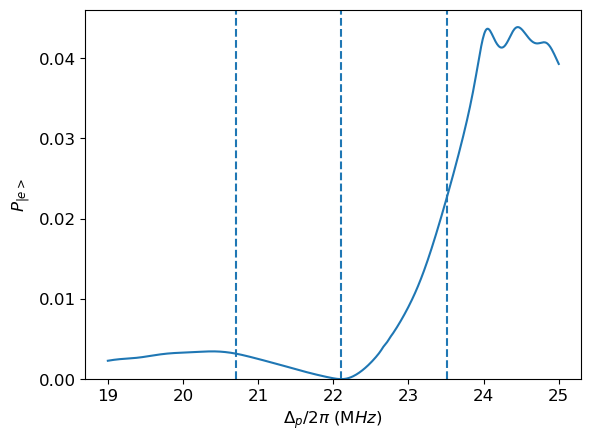

In [55]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,N2),pope)
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
#for i in range(len(Delta_ds)):
#        plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
        
#plt.axhline(0.04, linestyle='--')
plt.axvline(Delta_ds[-3], linestyle="--")
plt.axvline(Delta_ds[-3] + 1.4, linestyle="--")
plt.axvline(Delta_ds[-3] - 1.4, linestyle="--")
#plt.xlim(21,23)
#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [56]:
Delta = [0,10,Delta_ds[-3],20]

In [57]:
Delta = [0,10,Delta_ds[-3],20]
H0 = H_0(F,Delta)
HI = H_I(F,Omega_p)
H=H0+HI
L = -1j*(spre(H)-spost(H))


for i in range(len(c_ops)):
    L += spre(c_ops[i])*spost(c_ops[i].dag()) - 0.5*(spre(c_ops[i].dag()*c_ops[i]) + spost(c_ops[i].dag()*c_ops[i]))

In [58]:
L = L.data_as('ndarray')

In [59]:
eigenvalues, eigenvectors = eigs(L,k=5,sigma = 0+0j) #uniqueness of dark state

In [60]:
eigenvalues

array([-1.25384728e-17-2.55286793e-17j, -4.36059368e-06+3.88253245e-10j,
       -2.11324333e-05+2.44852852e-09j, -7.35282489e-05-4.29456594e-08j,
       -1.79611032e-04-1.21638967e-07j])

In [61]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [63,20,63]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [62]:
Dmin = 19
Dmax = 25
step2 = 1e-02
N2 = int((Dmax-Dmin)/step2)
N2

600

In [63]:
pope1,rho1 = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,N2)

100%|████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:40<00:00, 14.85it/s]


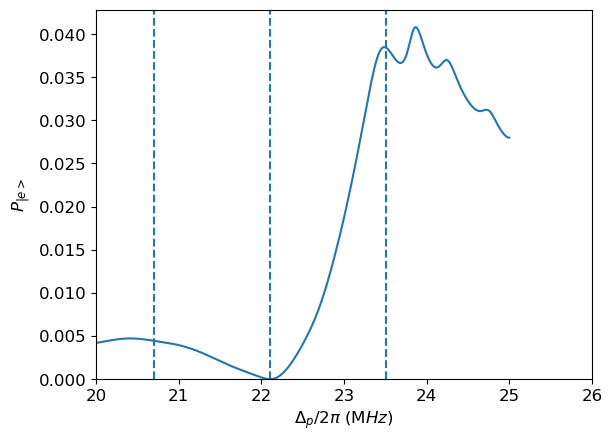

In [64]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,N2),pope1)
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
#for i in range(len(Delta_ds)):
#        plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
        
#plt.axhline(0.04, linestyle='--')
plt.axvline(Delta_ds[-3], linestyle="--")
plt.axvline(Delta_ds[-3] + 1.4, linestyle="--")
plt.axvline(Delta_ds[-3] - 1.4, linestyle="--")
plt.xlim(20,26)
#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [65]:
Delta = [0,10,Delta_ds[-3],20]
H0 = H_0(F,Delta)
HI = H_I(F,Omega_p)
H=H0+HI
L = -1j*(spre(H)-spost(H))

for i in range(len(c_ops)):
    L += spre(c_ops[i])*spost(c_ops[i].dag()) - 0.5*(spre(c_ops[i].dag()*c_ops[i]) + spost(c_ops[i].dag()*c_ops[i]))

In [66]:
L = L.data_as('ndarray')

In [67]:
eigenvalues, eigenvectors = eigs(L,k=5,sigma = 0+0j)

In [68]:
eigenvalues

array([-1.39813815e-17-7.07638264e-17j, -7.35594413e-06-2.28331193e-10j,
       -3.91160941e-05-4.55078176e-09j, -1.49440230e-04+1.29554275e-08j,
       -3.54929747e-04+3.40017620e-08j])

In [69]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [73,19,73]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [70]:
pope2,rho2 = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,N2)

100%|████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:41<00:00, 14.51it/s]


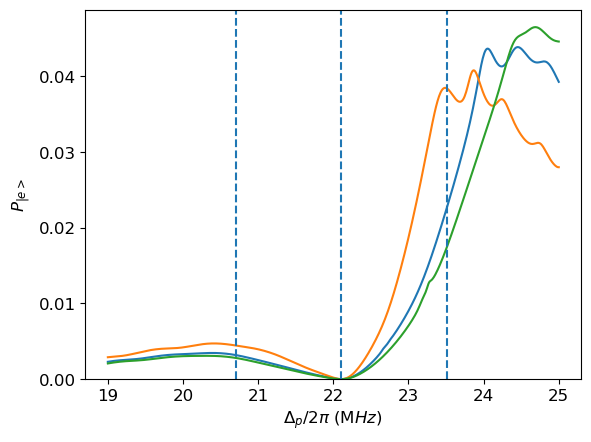

In [71]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,N2),pope)
plt.plot(np.linspace(Dmin,Dmax,N2),pope1)
plt.plot(np.linspace(Dmin,Dmax,N2),pope2)
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
#for i in range(len(Delta_ds)):
#        plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
        
#plt.axhline(0.04, linestyle='--')
plt.axvline(Delta_ds[-3], linestyle="--")
plt.axvline(Delta_ds[-3] + 1.4, linestyle="--")
plt.axvline(Delta_ds[-3] - 1.4, linestyle="--")
#plt.xlim(20,26)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [72]:
Delta_ds[-3]

22.106462482098618

In [73]:
Delta = [0,10,Delta_ds[-3],20]
H0 = H_0(F,Delta)
HI = H_I(F,Omega_p)
H=H0+HI
L = -1j*(spre(H)-spost(H))
for i in range(len(c_ops)):
    L += spre(c_ops[i])*spost(c_ops[i].dag()) - 0.5*(spre(c_ops[i].dag()*c_ops[i]) + spost(c_ops[i].dag()*c_ops[i]))

In [74]:
L = L.data_as('ndarray')

In [75]:
eigenvalues, eigenvectors = eigs(L,k=10,sigma = 0+0j)

In [76]:
eigenvalues

array([-4.21621376e-18-1.90116306e-17j, -3.68298076e-06-9.69288189e-11j,
       -1.75157670e-05+2.65188446e-11j, -5.99331310e-05-1.98925587e-08j,
       -1.47978460e-04-2.69253352e-07j, -3.02745272e-04-1.78748563e-07j,
       -5.15818049e-04+4.99981692e-08j, -8.17940464e-04-2.15206440e-06j,
       -1.08709273e-03-3.84546920e-06j, -1.80217368e-03+2.59017843e-06j])

In [77]:
eta = 0.044
omega0 = 1.4
GammaJgJe = 2.44745

In [78]:
pope[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope[int((Delta_ds[-3]-omega0-Dmin)/step2)]

0.019351129916150105

In [79]:
pope1[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope1[int((Delta_ds[-3]-omega0-Dmin)/step2)]

0.03398930718907591

In [80]:
pope2[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope2[int((Delta_ds[-3]-omega0-Dmin)/step2)]

0.014540976426490819

In [81]:
wabs = np.array([pope2[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope2[int((Delta_ds[-3]-omega0-Dmin)/step2)],
                pope1[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope1[int((Delta_ds[-3]-omega0-Dmin)/step2)],
                pope[int((Delta_ds[-3]+omega0-Dmin)/step2)] - pope[int((Delta_ds[-3]-omega0-Dmin)/step2)]])
wabs = 2*np.pi*GammaJgJe*eta**2*wabs

In [82]:
wabs

array([0.00043291, 0.00101191, 0.00057611])

## Fictitious lasers

In [84]:
df = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_70_O22_19_omega_1.4_steck_2000.txt",dtype='complex')[:, 0]
pf = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_70_O22_19_omega_1.4_steck_2000.txt",dtype='complex')[:, 1]

C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


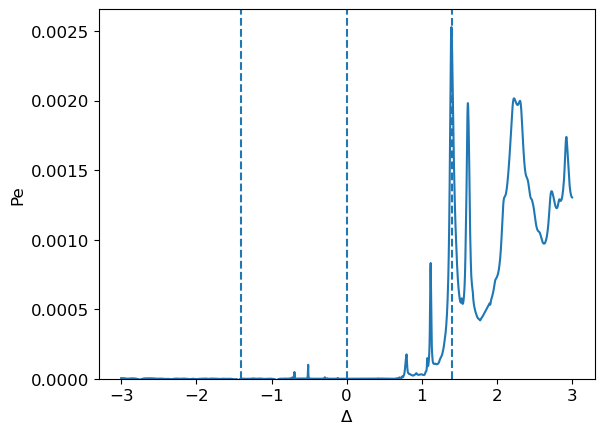

In [85]:
plt.figure()
plt.plot(df,pf)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0)

plt.show()

In [86]:
df1 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_63_O22_20_omega_1.4_steck_2000.txt",dtype='complex')[:, 0]
pf1 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_63_O22_20_omega_1.4_steck_2000.txt",dtype='complex')[:, 1]

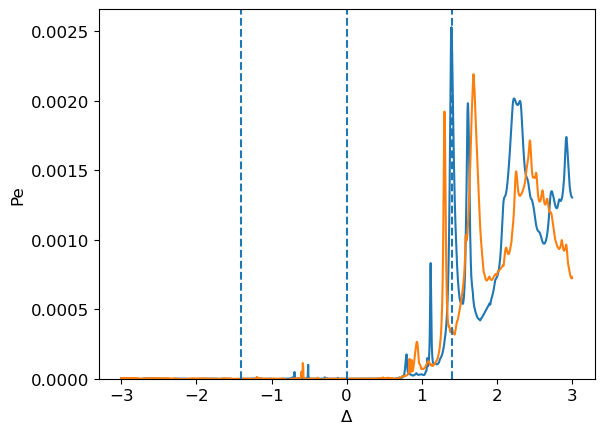

In [87]:
plt.figure()
plt.plot(df,pf)
plt.plot(df1,pf1)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0)

plt.show()

In [88]:
df2 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_73_O22_19_omega_1.4_steck_2000.txt",dtype='complex')[:, 0]
pf2 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_73_O22_19_omega_1.4_steck_2000.txt",dtype='complex')[:, 1]

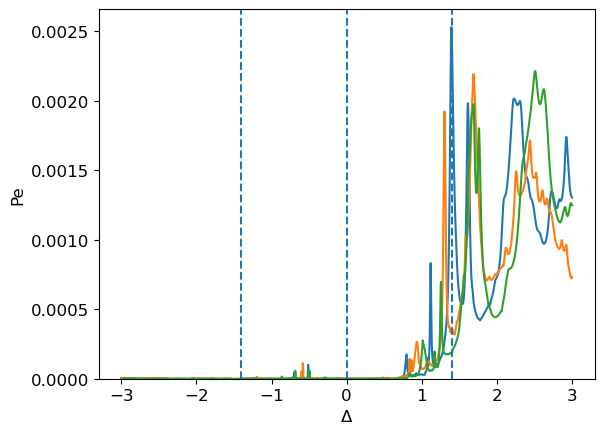

In [89]:
plt.figure()
plt.plot(df,pf)
plt.plot(df1,pf1)
plt.plot(df2,pf2)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0)

plt.show()

In [90]:
step = (df[-1]-df[0])/len(df)
step

(0.003+0j)

In [91]:
omega0=1.4

In [92]:
pf[int((omega0-df[0])/step)].real - pf[int((-omega0-df[0])/step)].real

C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\547517977.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  pf[int((omega0-df[0])/step)].real - pf[int((-omega0-df[0])/step)].real


0.00243916

In [93]:
pf1[int((omega0-df[0])/step)].real - pf1[int((-omega0-df[0])/step)].real

C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\1996774498.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  pf1[int((omega0-df[0])/step)].real - pf1[int((-omega0-df[0])/step)].real


0.00036314

In [94]:
pf2[int((omega0-df[0])/step)].real - pf2[int((-omega0-df[0])/step)].real

C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\816153617.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  pf2[int((omega0-df[0])/step)].real - pf2[int((-omega0-df[0])/step)].real


0.0001809

In [95]:
w_tilde = np.array([(pf2[int((omega0-df[0])/step)] - pf2[int((-omega0-df[0])/step)]).real,
                   (pf1[int((omega0-df[0])/step)] - pf1[int((-omega0-df[0])/step)]).real,
                   (pf[int((omega0-df[0])/step)] - pf[int((-omega0-df[0])/step)]).real])

C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\4135775650.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  w_tilde = np.array([(pf2[int((omega0-df[0])/step)] - pf2[int((-omega0-df[0])/step)]).real,
C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\4135775650.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  (pf1[int((omega0-df[0])/step)] - pf1[int((-omega0-df[0])/step)]).real,
C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\4135775650.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  (pf[int((omega0-df[0])/step)] - pf[int((-omega0-df[0])/step)]).real])


In [96]:
w_tilde

array([0.0001809 , 0.00036314, 0.00243916])

## fluctuation spectrum

In [98]:
d = np.loadtxt("/Users/kfouka/Desktop/ΠΕ ++/qudits/eit cooling/numerics/MC/I7/fluctuation_spectrum/data_B4_D21_10_D23_20_O21_O23_70_O22_19_omega_1.4_2000.txt",dtype='complex')[:, 0]
p = np.loadtxt("/Users/kfouka/Desktop/ΠΕ ++/qudits/eit cooling/numerics/MC/I7/fluctuation_spectrum/data_B4_D21_10_D23_20_O21_O23_70_O22_19_omega_1.4_2000.txt",dtype='complex')[:, 1]

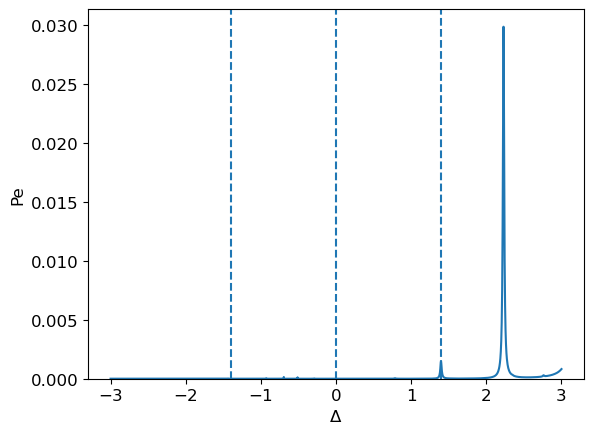

In [99]:
plt.figure()
plt.plot(d,p)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0)

plt.show()

In [100]:
d1 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_63_O22_20_omega_1.4_2000.txt",dtype='complex')[:, 0]
p1 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_63_O22_20_omega_1.4_2000.txt",dtype='complex')[:, 1]

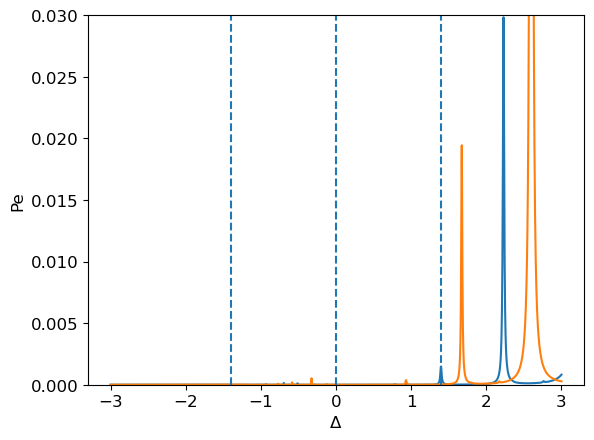

In [101]:
plt.figure()
plt.plot(d,p)
plt.plot(d1,p1)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0,0.03)

plt.show()

In [102]:
d2 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_73_O22_19_omega_1.4_2000.txt",dtype='complex')[:, 0]
p2 = np.loadtxt(""+str(path_name)+"data_B4_D21_10_D23_20_O21_O23_73_O22_19_omega_1.4_2000.txt",dtype='complex')[:, 1]

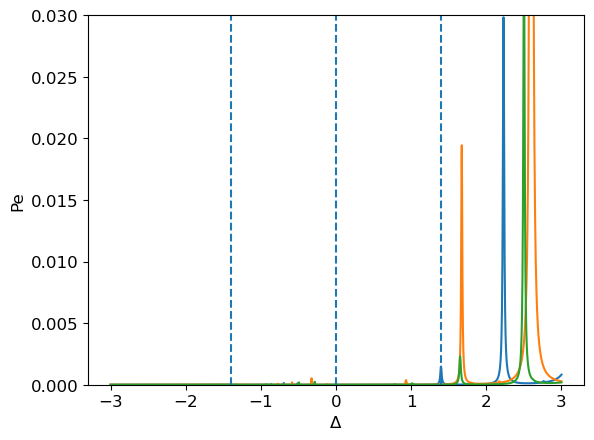

In [103]:
plt.figure()
plt.plot(d,p)
plt.plot(d1,p1)
plt.plot(d2,p2)
plt.axvline(0, linestyle="--")
plt.axvline(0 + 1.4, linestyle="--")
plt.axvline(0- 1.4, linestyle="--")
plt.ylabel('Pe')
plt.xlabel('Δ')
plt.ylim(0,0.03)

plt.show()

In [104]:
step = (d[-1]-d[0])/len(d)
step

(0.003+0j)

In [105]:
w = np.array([(p2[int((omega0-d[0])/step)] - p2[int((-omega0-d[0])/step)]).real,
                   (p1[int((omega0-d[0])/step)] - p1[int((-omega0-d[0])/step)]).real,
                   (p[int((omega0-d[0])/step)] - p[int((-omega0-d[0])/step)]).real])

C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\3265832917.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  w = np.array([(p2[int((omega0-d[0])/step)] - p2[int((-omega0-d[0])/step)]).real,
C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\3265832917.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  (p1[int((omega0-d[0])/step)] - p1[int((-omega0-d[0])/step)]).real,
C:\Users\kfouka\AppData\Local\Temp\ipykernel_2624\3265832917.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  (p[int((omega0-d[0])/step)] - p[int((-omega0-d[0])/step)]).real])


In [106]:
w

array([6.68000e-06, 1.95200e-05, 1.32668e-03])

In [107]:
w_tilde

array([0.0001809 , 0.00036314, 0.00243916])

## cooling

In [161]:
def func(x,Nmax,nbar):
    
    Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))
    n = np.exp(-Nmax*x)*(np.exp((Nmax + 1)*x) -(Nmax+1)*np.exp(x) + Nmax)/(np.exp(x) -1)**2
    
    
    return np.abs(nbar - n/Z)

In [163]:
Nmax=14
nbar=3
res = minimize_scalar(func,args=(Nmax,nbar),bounds=(0, 1), method='bounded')

In [165]:
x = res.x

In [167]:
hbar = 1.054571817e-34
kB = 1.380649e-23
omega = 2*np.pi*1.4*10e6
#x = 0.184132
Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))

T = hbar*omega/(kB*x)
T

0.002527075613606284

In [169]:
P = []
for i in range(Nmax+1): #Nmotion=15 but for <n> =3 keep up to i=10
    P.append(np.exp(-i*x)/Z)

In [171]:
Pn = []
for i in range(Nmax+1):
    Pn.append(np.exp(-i*x)/Z*i)

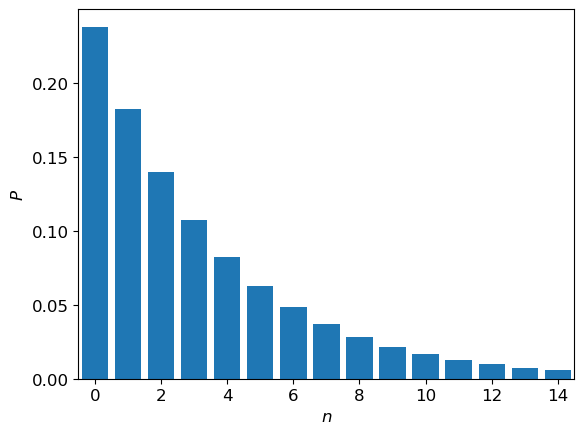

In [173]:
plt.figure()
plt.bar(np.arange(0,Nmax+1),P)
plt.ylabel('$P$')
plt.xlabel('$n$')
plt.xlim(-0.5,Nmax+0.5)
plt.show()

In [175]:
n = []
t = []
n_dev = []
for i in range(Nmax+1):
    t.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_70_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_70_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_dev.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_70_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_stds_improved_step.txt")[:, 0])

In [176]:
nMC = np.zeros(len(t[0]))
for i in range(Nmax + 1):
    nMC +=n[i]*P[i]

In [177]:
nMC_dev = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC_dev +=n_dev[i]*P[i]

nMC_dev=nMC_dev/np.sqrt(500-1)

In [178]:
n1 = []
t1 = []
n_dev1 = []
for i in range(Nmax+1):
    t1.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_63_O11_20_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n1.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_63_O11_20_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_dev1.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_63_O11_20_"+str(i)+"_Gamma_2.44745_ntraj_500_stds_improved_step.txt")[:, 0])

In [179]:
nMC1 = np.zeros(len(t1[0]))
for i in range(Nmax + 1):
    nMC1 +=n1[i]*P[i]

In [183]:
nMC_dev1 = np.zeros(len(t1[0]))
for i in range(Nmax+1):
    nMC_dev1 +=n_dev1[i]*P[i]

nMC_dev1=nMC_dev1/np.sqrt(500-1)

In [205]:
n2 = []
t2 = []
n_dev2 = []
for i in range(Nmax+1):
    t2.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_73_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n2.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_73_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_dev2.append(np.loadtxt(""+str(path_name)+"data_B4.0_D10_10_D12_20_O10_O11_73_O11_19_"+str(i)+"_Gamma_2.44745_ntraj_500_stds_improved_step.txt")[:, 0])

In [206]:
nMC2 = np.zeros(len(t2[0]))
for i in range(Nmax + 1):
    nMC2 +=n2[i]*P[i]

In [207]:
nMC_dev2 = np.zeros(len(t2[0]))
for i in range(Nmax+1):
    nMC_dev2 +=n_dev2[i]*P[i]

nMC_dev2=nMC_dev2/np.sqrt(500-1)

In [208]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [225]:
p0 = (3, .001,.001)
popt, pcov = curve_fit(func,t[0],nMC,p0)
popt

array([2.92807155e+00, 1.28151163e-03, 1.14692978e-01])

In [227]:
popt1, pcov1 = curve_fit(func,t1[0],nMC1,p0)
popt1

array([2.90137863e+00, 6.08194056e-04, 3.81689453e-01])

In [229]:
popt2, pcov2 = curve_fit(func,t2[0],nMC2,p0)
popt2

array([2.84400706e+00, 1.08703944e-03, 3.24082239e-01])

In [231]:
len(t2[0])

12000

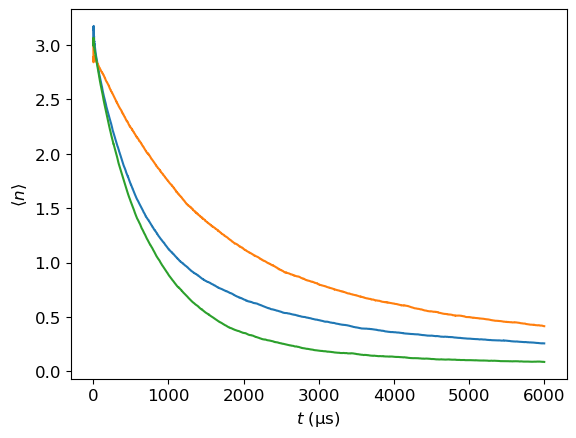

In [233]:

plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
#plt.errorbar(t2[0],nMC2,yerr = nMC_dev2,color='#cccccc',ecolor='#cccccc')
#plt.plot(t2[0],nMC2)
#plt.plot(t2[0],func(t2[0], *popt2),'--')

#plt.errorbar(t[0],nMC,yerr = nMC_dev,color='#cccccc',ecolor='#cccccc')
#plt.plot(t[0],nMC)
#plt.plot(t[0],func(t[0], *popt),'--')

plt.plot(t2[0],nMC2)
plt.plot(t1[0],nMC1)
#plt.plot(t1[0],func(t1[0], *popt1),'--')
plt.plot(t[0],nMC)
#plt.plot(t[0],func(t[0], *popt),'--')



plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")


#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [235]:
nMC[8000]

0.13360915615752766

In [237]:
wexp = np.array([popt2[1],popt1[1],popt[1]])

In [239]:
wexp

array([0.00108704, 0.00060819, 0.00128151])

In [241]:
w

array([6.68000e-06, 1.95200e-05, 1.32668e-03])

In [243]:
w_tilde

array([0.0001809 , 0.00036314, 0.00243916])

In [245]:
wabs

array([0.00043291, 0.00101191, 0.00057611])

In [247]:
len(nMC_dev)

12000

C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


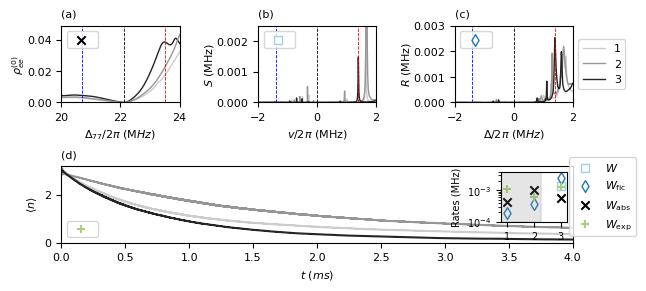

In [253]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 8})
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax4%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=(5.8,2.8))

gs = GridSpec(2, 3, figure=fig)
#gs.update(wspace=0.005, hspace=0.005)

# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))


ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title(r'(a)',loc='left',fontdict={'fontsize': 8})
ax1.plot(np.linspace(Dmin,Dmax,N2),pope2,color='#cccccc',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,N2),pope1,color='#252525',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,N2),pope,color='#969696',linewidth=1)
ax1.axvline(Delta_ds[-3]+1.4, linestyle='--',color='red',linewidth=0.6)
ax1.axvline(Delta_ds[-3], linestyle='--',color='black',linewidth=0.6)
ax1.axvline(Delta_ds[-3]- 1.4, linestyle='--',color='blue',linewidth=0.6)
ax1.scatter([3],2*wabs[-1],marker='x',label='$\,$',color='black')
ax1.set_xlim(20,24)
ax1.set_ylim(0)
ax1.set_ylabel(r'$\rho_{ee}^{(0)}$',labelpad=0)
ax1.set_xlabel('$Δ_{77}/2π \ (ΜHz)$')
ax1.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)
#ax1.ticklabel_format(axis='y', scilimits=[-3, -2])
#plt.ylim(0)


ax3 = fig.add_subplot(gs[0, 1])
ax3.set_title(r'(b)',loc='left',fontdict={'fontsize': 8})
ax3.plot(d2,p2,color='#cccccc',linewidth=1)
ax3.plot(d1,p1,color='#969696',linewidth=1)
ax3.plot(d,p,color='#252525',linewidth=1)
ax3.scatter([1],w.real[-1] +10,marker='s',label=r'$\,$',color='white',edgecolor = '#a6cee3')
ax3.set_ylabel('$S$ (MHz)',labelpad=0)
ax3.set_xlabel('$v/2π$ (ΜHz)')
ax3.set_ylim(0,0.0025)
ax3.set_xlim(-2,2)
ax3.axvline(1.4, linestyle='--',color='red',linewidth=0.6)
ax3.axvline(0, linestyle='--',color='black',linewidth=0.6)
ax3.axvline(- 1.4, linestyle='--',color='blue',linewidth=0.6)
ax3.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)
#ax3.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title(r'(c)',loc='left',fontdict={'fontsize': 8})
line1,=ax2.plot(df2,pf2,color='#cccccc',label='1',linewidth=1)
line2,=ax2.plot(df1,pf1,color='#969696',label='2',linewidth=1)
line3,=ax2.plot(df,pf,color='#252525',label='3',linewidth=1)
line4=ax2.scatter([1,2,3],w_tilde.real+10,marker='d',label=r'$\,$',color='white',edgecolor = '#1f78b4')
ax2.axvline(1.4, linestyle='--',color='red',linewidth=0.6)
ax2.axvline(0, linestyle='--',color='black',linewidth=0.6)
ax2.axvline( - 1.4, linestyle='--',color='blue',linewidth=0.6)
ax2.set_ylabel('$R$ (MHz)',labelpad=0)
ax2.set_xlabel('$Δ/2π \ (ΜHz)$')
ax2.set_ylim(0,0.003)
ax2.set_xlim(-2,2)
#ax2.ticklabel_format(axis='y', scilimits=[-4, -3])
ax2.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
first_legend =plt.legend(handles=[line1,line2,line3],loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
ax2.add_artist(first_legend)
second_legend = plt.legend(handles=[line4],loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)

ax4 = fig.add_subplot(gs[1, :])
ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 8})
ax4.errorbar(t2[0]*1e-3,nMC2,yerr = nMC_dev2,color='#cccccc',ecolor='#cccccc')
ax4.errorbar(t1[0]*1e-3,nMC1,yerr = nMC_dev1,color='#969696',ecolor='#969696')
ax4.errorbar(t[0]*1e-3,nMC,yerr = nMC_dev,color='#252525',ecolor='#252525')
ax4.scatter([1,2,3],np.array(wexp)+10,marker='+',label=r'$\,$',color='#a7cf82')
ax4.set_ylabel(r'$ \langle n \rangle $')
ax4.set_xlabel(r'$t \ (ms)$')
ax4.set_ylim(0,3.2)
ax4.set_xlim(0,4)
#plt.xlim(0,100)
#ax4.legend(prop={'size': 10})
ax4.legend(loc='lower left',alignment='left',handletextpad=0.05,borderpad=0.3,columnspacing=0.05)


inset_ax = inset_axes(ax4, width="13%", height=0.5, loc="upper right")
#inset_ax.set_title(r'(e)',loc='left',fontdict={'fontsize': 8},pad=5)
#inset_ax.fill_between(np.linspace(2.75,3.25,1000),y1=1e-4,y2=1, color='grey', alpha=0.2)
inset_ax.scatter([1,2,3],w,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3')
inset_ax.scatter([1,2,3],w_tilde,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4')
inset_ax.scatter([1,2,3],wabs,marker='x',label=r'$W_{\text{abs}}$',color='black')
inset_ax.scatter([1,2,3],wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82')
inset_ax.fill_between(np.linspace(0.75,2.25,1000),y1=1e-4,y2=4e-3, color='grey', alpha=0.2)
inset_ax.set_xticks([1,2,3])
inset_ax.set_xticklabels(["1","2","3"])
inset_ax.set_ylim(1e-4,4e-3)
inset_ax.set_xlim(0.75,3.25)
inset_ax.tick_params(labelsize=7)
inset_ax.set_yscale('log')
inset_ax.set_ylabel('Rates (MHz)',fontsize=7)
inset_ax.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(0.95, 0.5))
#ax4.set_xlabel('Cases')
#plt.xticks([]); plt.yticks([])  # strip ticks, which collide w/ main ax


#ax4 = fig.add_subplot(gs[2:, :2])
#ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 10}, pad=10)
#ax4.scatter([1,2,3],w,marker='o',label='$W$',color=['black','royalblue','lightblue'])
#ax4.scatter([1,2,3],w_tilde,marker='*',label='$\widetilde{W}$',color=['black','royalblue','lightblue'])
#ax4.scatter([1,2,3],w_exp,marker='p',label='$W_{exp}$',color=['black','royalblue','lightblue'])
#ax4.set_xticks([1,2,3])
#ax4.set_xticklabels(["1","2","3"])
#ax4.set_yscale('log')


#ax4.set_ylabel('Cooling Rates (MHz)')
#ax4.set_xlabel('Cases')

#ax4.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
#plt.xlim(45,55)

#fig.suptitle("GridSpec")
#format_axes(fig)


plt.savefig("I7_all.pdf",bbox_inches = "tight")

plt.show()